In [19]:
from keras.layers import Input, Dense, Lambda, Flatten, Activation, Merge, Concatenate, Add
from keras import layers
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler

import numpy as np
from scipy.stats import sem
from keras import backend as K
from keras.models import load_model
import tensorflow as tf


from models import vgg
from models.cvae import CVAE
from models.cvae_mod import CVAE as CVAE_mod
from utils.losses import von_mises_log_likelihood_np
from utils.angles import deg2bit, bit2deg, bit2deg_multi
from utils.losses import mad_loss_tf, cosine_loss_tf, von_mises_loss_tf, maad_from_deg
from utils.losses import gaussian_kl_divergence_tf, gaussian_kl_divergence_np
from utils.losses import gaussian_log_likelihood_np, gaussian_log_likelihood_scipy, gaussian_log_likelihood_tf
from utils.losses  import von_mises_log_likelihood_tf, von_mises_log_likelihood_np
from utils.losses import maximum_expected_utility, importance_loglikelihood
from utils.towncentre import load_towncentre, aug_data
from utils.experiements import get_experiment_id

#### Loading dataset

In [2]:
xtr, ytr_deg, xval, yval_deg, xte, yte_deg = load_towncentre('data/TownCentre.pkl.gz', canonical_split=True, verbose=1)

image_height, image_width = xtr.shape[1], xtr.shape[2]

ytr_bit = deg2bit(ytr_deg)
yval_bit = deg2bit(yval_deg)
yte_bit = deg2bit(yte_deg)
yte_rad = np.deg2rad(yte_deg)

image_height, image_width, n_channels = xtr.shape[1:]
flatten_x_shape = xtr[0].flatten().shape[0]
phi_shape = yte_bit.shape[1]

Number of train samples: 6916
Number of validation samples: 874
Number of test samples: 904


#### Loading pre-trained models

#### Biternion-VGG (cosine-loss)

In [6]:
vgg_cosine = vgg.BiternionVGG(image_height=image_height,
                              image_width=image_width,
                              n_channels=3,
                              predict_kappa=False,
                              fixed_kappa_value=3.0)

vgg_cosine.model.load_weights('../biternion_net_cluster_logs/best_models/cosine/vgg_bit_cosine_town.best.weights.h5')

results_cosine = dict()
results_cosine['train'] = vgg_cosine.evaluate(xtr, ytr_deg, 'train')
results_cosine['validation'] = vgg_cosine.evaluate(xval, yval_deg, 'validation')
results_cosine['test'] = vgg_cosine.evaluate(xte, yte_deg, 'test')

MAAD error (train) : 6.394312 ± 0.073692SEM
log-likelihood (train) : -0.456771 ± 0.001295SEM
MAAD error (validation) : 21.833931 ± 0.966800SEM
log-likelihood (validation) : -0.843196 ± 0.034713SEM
MAAD error (test) : 24.108348 ± 1.069605SEM
log-likelihood (test) : -0.926001 ± 0.038936SEM


#### Biternion-VGG (Von-Mises loss)

In [7]:
vgg_vm = vgg.BiternionVGG(image_height=image_height,
                          image_width=image_width,
                          n_channels=3,
                          predict_kappa=False,
                          fixed_kappa_value=3.0)

vgg_vm.model.load_weights('../biternion_net_cluster_logs/best_models/von_mises/vgg_bit_von_mises_town.best.weights.h5')

results_vm = dict()
results_vm['train'] = vgg_vm.evaluate(xtr, ytr_deg, 'train')
results_vm['validation'] = vgg_vm.evaluate(xval, yval_deg, 'validation')
results_vm['test'] = vgg_vm.evaluate(xte, yte_deg, 'test')

vm_preds = vgg_vm.model.predict(xte)
vm_preds_mu_rad = np.deg2rad(bit2deg(vm_preds))
vm_preds_kappa = np.ones([xte.shape[0],1])*3
vm_preds_likelihoods = von_mises_log_likelihood_np(yte_bit, vm_preds[:,0:2], vm_preds_kappa)

MAAD error (train) : 9.459415 ± 0.142856SEM
log-likelihood (train) : -0.510601 ± 0.004218SEM
MAAD error (validation) : 22.974047 ± 0.999363SEM
log-likelihood (validation) : -0.883493 ± 0.036697SEM
MAAD error (test) : 24.156092 ± 1.083819SEM
log-likelihood (test) : -0.925846 ± 0.039583SEM


#### Biternion-VGG (log-likelihood, fixed  $\kappa=3$ )

In [8]:
vgg_fixed_kappa = vgg.BiternionVGG(image_height=image_height,
                                   image_width=image_width,
                                   n_channels=3,
                                   predict_kappa=False,
                                   fixed_kappa_value=3.0)

vgg_fixed_kappa.model.load_weights('../biternion_net_cluster_logs/best_models/fixed_kappa/vgg_bit_vm_likelihood_town.best.weights.h5')

results_fixed = dict()
results_fixed['train'] = vgg_fixed_kappa.evaluate(xtr, ytr_deg, 'train')
results_fixed['validation'] = vgg_fixed_kappa.evaluate(xval, yval_deg, 'validation')
results_fixed['test'] = vgg_fixed_kappa.evaluate(xte, yte_deg, 'test')

fixed_preds = vgg_fixed_kappa.model.predict(xte)
fixed_preds_mu_rad = np.deg2rad(bit2deg(fixed_preds))
fixed_preds_kappa = np.ones([xte.shape[0],1])*3
fixed_preds_likelihoods = von_mises_log_likelihood_np(yte_bit, fixed_preds[:,0:2], fixed_preds_kappa)

MAAD error (train) : 11.216375 ± 0.144446SEM
log-likelihood (train) : -0.533973 ± 0.003843SEM
MAAD error (validation) : 22.728342 ± 0.990586SEM
log-likelihood (validation) : -0.870462 ± 0.035802SEM
MAAD error (test) : 24.155143 ± 1.088582SEM
log-likelihood (test) : -0.929270 ± 0.039672SEM


#### Biternion-VGG (log-likelihood loss, learned  $\kappa$ )

In [9]:
vgg_learned_kappa = vgg.BiternionVGG(image_height=image_height,
                                     image_width=image_width,
                                     n_channels=3,
                                     predict_kappa=True)

vgg_learned_kappa.model.load_weights('../biternion_net_cluster_logs/best_models/learned_kappa/vgg_bit_vm_likelihood_town.best.weights.h5')

results_learned = dict()
results_learned['train'] = vgg_learned_kappa.evaluate(xtr, ytr_deg, 'train')
results_learned['validation'] = vgg_learned_kappa.evaluate(xval, yval_deg, 'validation')
results_learned['test'] = vgg_learned_kappa.evaluate(xte, yte_deg, 'test')

learned_preds = vgg_learned_kappa.model.predict(xte)
learned_preds_mu_rad = np.deg2rad(bit2deg(learned_preds[:,0:2]))
learned_preds_kappa = learned_preds[:,2:]
learned_preds_likelihoods = von_mises_log_likelihood_np(yte_bit, learned_preds[:,0:2], learned_preds_kappa)

MAAD error (train) : 14.462390 ± 0.213100SEM
log-likelihood (train) : -0.203715 ± 0.010644SEM
MAAD error (validation) : 24.398405 ± 1.090128SEM
log-likelihood (validation) : -0.802889 ± 0.078568SEM
MAAD error (test) : 24.327137 ± 1.095842SEM
log-likelihood (test) : -0.764323 ± 0.066594SEM


#### CVAE model (normal training)

In [10]:
n_samples = 10
n_u = 8
cvae = CVAE(n_hidden_units=n_u)
cvae_ckpt_path = '../biternion_net_cluster_logs/best_models/cvae/original_trainining/cvae.full_model.trial_0.best.weights.hdf5'
cvae.full_model.load_weights(cvae_ckpt_path)

results_cvae = dict()
results_cvae['train'] = cvae.evaluate_multi(xtr, ytr_deg, 'train')
results_cvae['validation'] = cvae.evaluate_multi(xval, yval_deg, 'validation', n_samples=n_samples)
results_cvae['test'] = cvae.evaluate_multi(xte, yte_deg, 'test', n_samples=n_samples)

cvae_preds = cvae.get_multiple_predictions(xte, yte_bit, n_samples=n_samples)
cvae_preds_likelihoods = von_mises_log_likelihood_np(yte_bit, cvae_preds['mu_bit_dec'][:,0], cvae_preds['kappa_dec'][:,0])

MAAD error (train) : 13.401158 ± 0.209671SEM
ELBO (train) : -0.159937 ± 0.007916SEM
Approx Log-Likelihood, importance sampling (train) : -0.159711 ± 0.007911SEM
KL-div (train) : 0.000001 ± 0.000000SEM
MAAD error (validation) : 24.826060 ± 1.161586SEM
ELBO (validation) : -0.635584 ± 0.043728SEM
Approx Log-Likelihood, importance sampling (validation) : -0.633394 ± 0.043381SEM
KL-div (validation) : 0.000001 ± 0.000000SEM
MAAD error (test) : 24.265253 ± 1.116603SEM
ELBO (test) : -0.676804 ± 0.053363SEM
Approx Log-Likelihood, importance sampling (test) : -0.675854 ± 0.053298SEM
KL-div (test) : 0.000001 ± 0.000000SEM


#### CVAE model (KL annealing)

In [11]:
n_samples = 10
n_u = 8
cvaekl = CVAE(n_hidden_units=n_u)
cvaekl_ckpt_path = '../biternion_net_cluster_logs/best_models/cvae/kl_annealing/cvae.full_model.trial_1.best.weights.hdf5'
cvaekl.full_model.load_weights(cvaekl_ckpt_path)

results_cvaekl = dict()
results_cvaekl['train'] = cvaekl.evaluate_multi(xtr, ytr_deg, 'train', n_samples=n_samples)
results_cvaekl['validation'] = cvaekl.evaluate_multi(xval, yval_deg, 'validation', n_samples=n_samples)
results_cvaekl['test'] = cvaekl.evaluate_multi(xte, yte_deg, 'test', n_samples=n_samples)

cvaekl_preds = cvaekl.get_multiple_predictions(xte, yte_bit, n_samples=n_samples)

cvaekl_approx_likelihood = importance_loglikelihood(cvaekl_preds['mu_encoder'], cvaekl_preds['log_sigma_encoder'],
                     cvaekl_preds['mu_prior'], cvaekl_preds['log_sigma_prior'],
                     cvaekl_preds['u_encoder'],
                     cvaekl_preds['mu_bit'], cvaekl_preds['kappa'],
                     yte_bit)

MAAD error (train) : 10.611419 ± 0.161833SEM
ELBO (train) : 0.030102 ± 0.006998SEM
Approx Log-Likelihood, importance sampling (train) : 0.046411 ± 0.006896SEM
KL-div (train) : 0.065087 ± 0.001248SEM
MAAD error (validation) : 25.618369 ± 1.135152SEM
ELBO (validation) : -0.707985 ± 0.051111SEM
Approx Log-Likelihood, importance sampling (validation) : -0.679394 ± 0.049045SEM
KL-div (validation) : 0.205767 ± 0.014709SEM
MAAD error (test) : 25.172874 ± 1.172574SEM
ELBO (test) : -0.731988 ± 0.056291SEM
Approx Log-Likelihood, importance sampling (test) : -0.688298 ± 0.053729SEM
KL-div (test) : 0.206518 ± 0.015021SEM


#### CVAE model (augmentation with opposite angles)

In [14]:
# n_u = 8
# cvaeaug = CVAE(n_hidden_units=n_u)
# cvaeaug_ckpt_path = '../biternion_net_cluster_logs/best_models/cvae/opposite_labels_aug/cvae.full_model.trial_0.best.weights.hdf5'
# cvaeaug.full_model.load_weights(cvaeaug_ckpt_path)

# xtr_aug, ytr_aug_deg = aug_data(xtr, ytr_deg)
# xval_aug, yval_aug_deg = aug_data(xval, yval_deg)
# xte_aug, yte_aug_deg = aug_data(xte, yte_deg)
# ytr_aug_bit = deg2bit(ytr_aug_deg)
# yval_aug_bit = deg2bit(yval_aug_deg)
# yte_aug_bit = deg2bit(yte_aug_deg)

# results_cvaeaug = dict()
# results_cvaeaug['train'] = cvaeaug.evaluate(xtr_aug, ytr_aug_deg, 'train')
# results_cvaeaug['validation'] = cvaeaug.evaluate(xval_aug, yval_aug_deg, 'validation')
# results_cvaeaug['test'] = cvaeaug.evaluate(xte_aug, yte_aug_deg, 'test')

# cvaeaug_preds = cvaekl.get_multiple_predictions(xte, yte_bit, n_samples=n_samples)

AttributeError: 'CVAE' object has no attribute 'evaluate'

#### Unconditioned decoder

In [ ]:
from models.cvae_unconditioned_decoder import CVAE as CVAE_unc

n_samples = 10
n_u = 8
cvaeunc = CVAE_unc(n_hidden_units=n_u)
cvaeunc_ckpt_path = '../biternion_net_cluster_logs/best_models/cvae/unconditioned_decoder/cvae.full_model.trial_0.best.weights.hdf5'
cvaeunc.full_model.load_weights(cvaeunc_ckpt_path)

results_cvaeunc = dict()
results_cvaeunc['train'] = cvaeunc.evaluate_multi(xtr, ytr_deg, 'train', n_samples=n_samples)
results_cvaeunc['validation'] = cvaeunc.evaluate_multi(xval, yval_deg, 'validation', n_samples=n_samples)
results_cvaeunc['test'] = cvaeunc.evaluate_multi(xte, yte_deg, 'test', n_samples=n_samples)

cvaeunc_preds = cvaeunc.get_multiple_predictions(xte, yte_bit, n_samples=n_samples)

cvaeunc_approx_likelihood = importance_loglikelihood(cvaeunc_preds['mu_encoder'], cvaeunc_preds['log_sigma_encoder'],
                     cvaeunc_preds['mu_prior'], cvaeunc_preds['log_sigma_prior'],
                     cvaeunc_preds['u_encoder'],
                     cvaeunc_preds['mu_bit'], cvaeunc_preds['kappa'],
                     yte_bit)

In [17]:
from utils.losses import log_bessel_approx_np

def vm_pdf(vals, mu_rad, kappa):
    return np.exp(kappa * np.cos(vals-mu_rad)) / (2* np.pi * np.exp(log_bessel_approx_np(kappa)))

import matplotlib.pyplot as plt
%matplotlib inline


def plot_vm_dists(fid):
    x_vals = np.arange(0, 2*np.pi, 0.01)
    
    fig, axs = plt.subplots(1, 7, figsize=(25, 5))
    
    axs[0].imshow(xte[fid])
    
    def _plt_vgg(axis, mu_rad_preds, kappa_preds, log_likelihoods, method_name):
        axis.set_xticks(([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]))
        axis.set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]) 
        axis.set_xlim([-0.001, 2*np.pi+0.001])
        axis.plot(x_vals, np.squeeze(vm_pdf(x_vals, mu_rad_preds[fid], kappa_preds[fid])))
        axis.axvline(yte_rad[fid], color='red')
        axis.set_title("%s (logL=%.2f)" % (method_name, log_likelihoods[fid]))
        axis.set_ylim([0, 2.0])
        
    def _plt_cvae(axis, cvae_mu_rad_preds, cvae_kappa_preds, log_likelihoods, method_name, plot_mixture=False):
        axis.set_xticks(([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]))
        axis.set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]) 
        axis.set_xlim([-0.001, 2*np.pi+0.001])
        vm_vals = np.zeros([n_samples, x_vals.shape[0]])
        if plot_mixture:
            for sid in range(0, n_samples):
                vm_vals[sid, :] = vm_pdf(x_vals, cvae_mu_rad_preds[fid, sid], cvae_kappa_preds[fid, sid])
            axis.plot(x_vals, np.mean(vm_vals, axis=0))
        else:
            for sid in range(0, n_samples):
                axis.plot(x_vals, np.squeeze(vm_pdf(x_vals, cvae_mu_rad_preds[fid, sid], cvae_kappa_preds[fid, sid])))  
        axis.axvline(yte_rad[fid], color='red')
        axis.set_title("%s (logL=%.2f)" % (method_name, log_likelihoods[fid]))
        axis.set_ylim([0, 2.0])
        
    _plt_vgg(axs[1], vm_preds_mu_rad, vm_preds_kappa, vm_preds_likelihoods, 'original (Von-Mises loss)')
    _plt_vgg(axs[2], fixed_preds_mu_rad, fixed_preds_kappa, fixed_preds_likelihoods,  'fixed kappa')
    _plt_vgg(axs[3], learned_preds_mu_rad, learned_preds_kappa, learned_preds_likelihoods, 'learned kappa')
    _plt_cvae(axs[4], cvae_preds['mu_rad_dec'], cvae_preds['kappa_dec'], cvae_preds_likelihoods, "CVAE (normal)")
    _plt_cvae(axs[5], cvaekl_preds['mu_rad_dec'],  cvaekl_preds['kappa_dec'], cvaekl_approx_likelihood, "CVAE (KL annealing)")
    _plt_cvae(axs[6], cvaekl_preds['mu_rad_dec'], cvaekl_preds['kappa_dec'], cvaekl_approx_likelihood, "CVAE (KL annealing, mixture density)", plot_mixture=True)
    # _plt_cvae(axs[7], cvaeaug_mu_rad_preds,  cvaeaug_kappa_preds, "CVAE (Random labels augmentation)")
    # _plt_cvae(axs[8], cvaeaug_mu_rad_preds, cvaeaug_kappa_preds, "CVAE (Random labels augmentation, mixture density)", plot_mixture=True)
    fig.suptitle("frame id =%d" %fid)
    #plt.plot((ytr_deg, x2), (y1, y2), 'k-')
    plt.show()

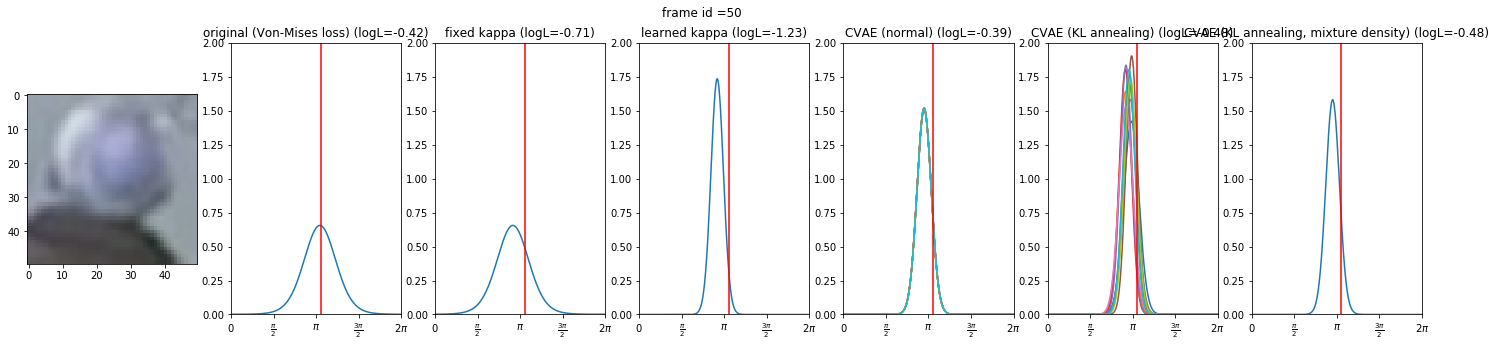

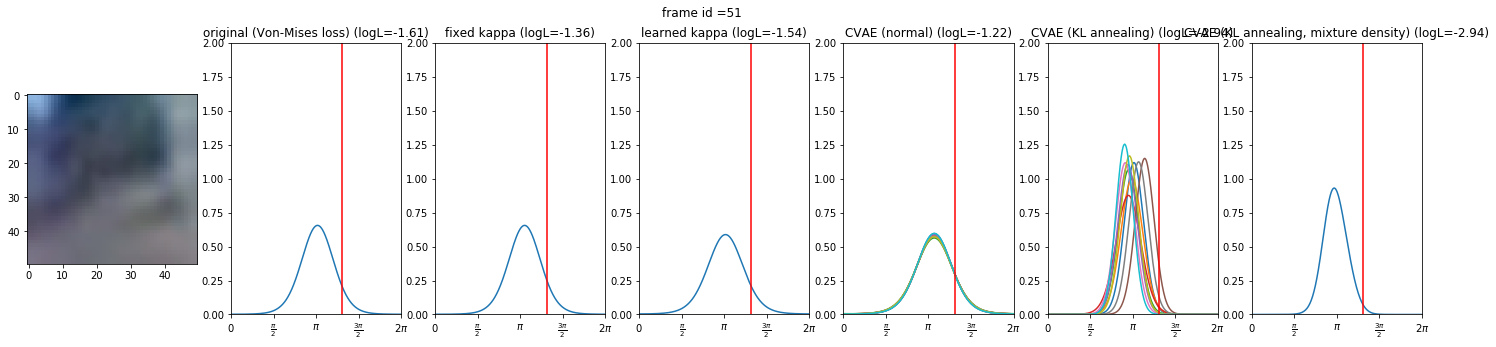

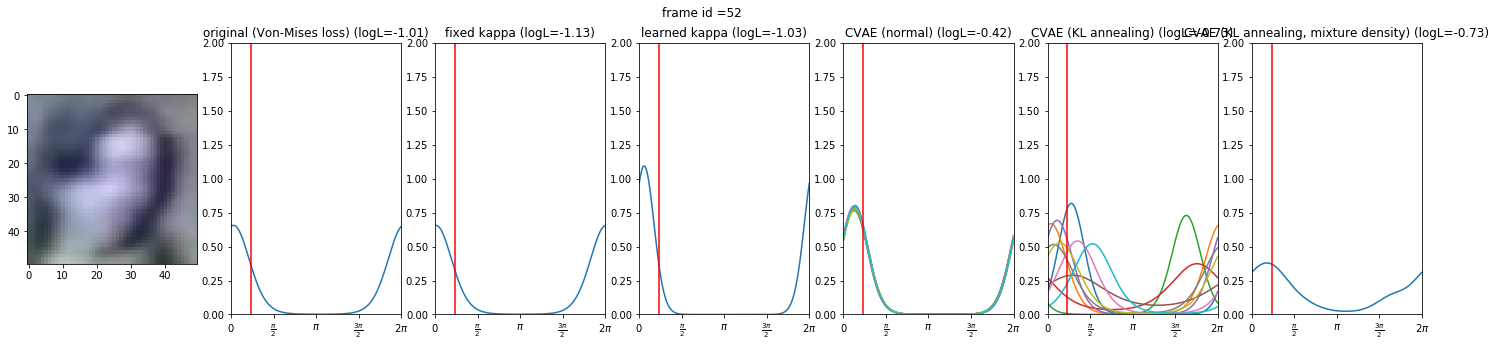

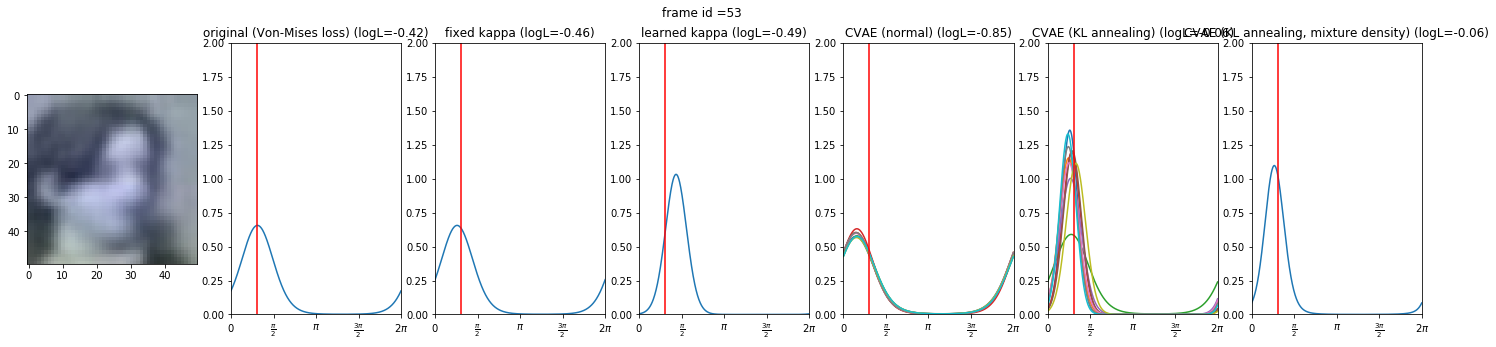

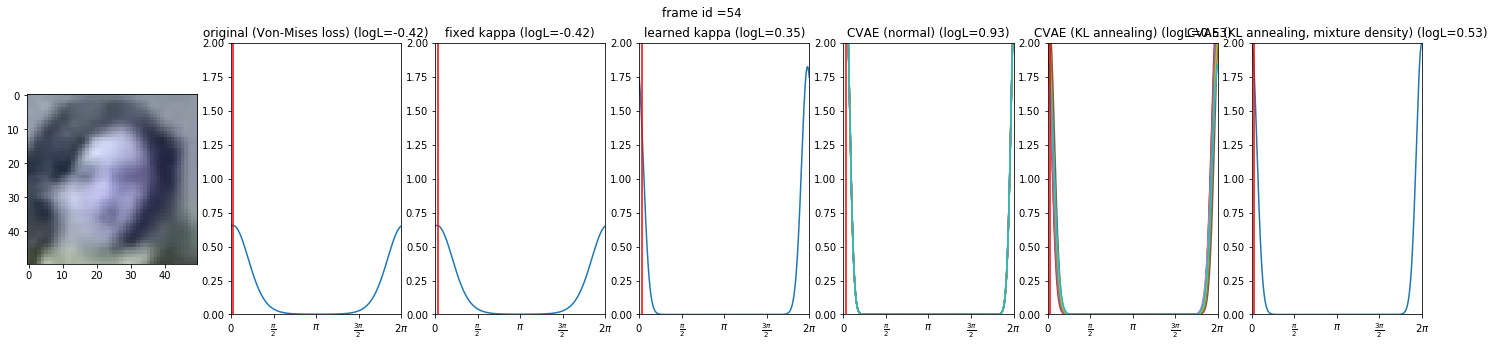

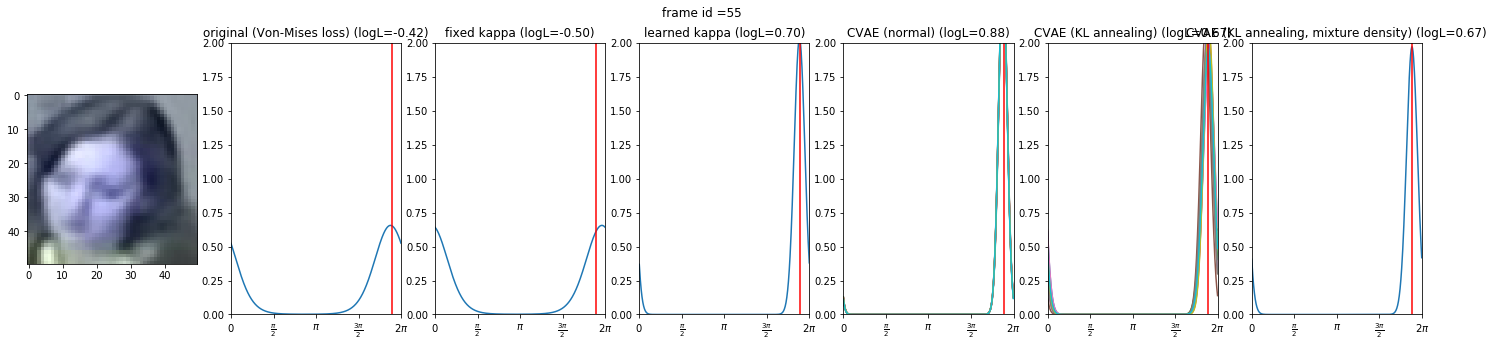

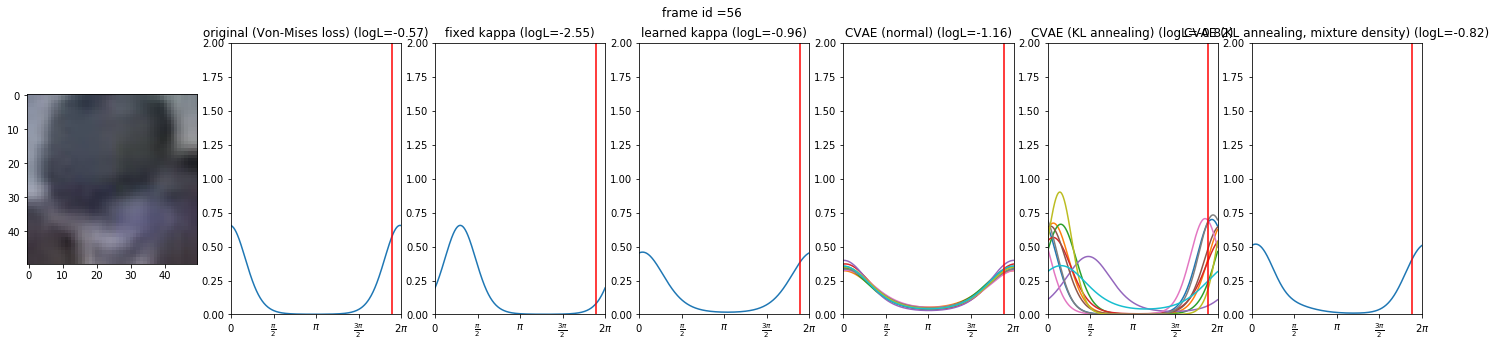

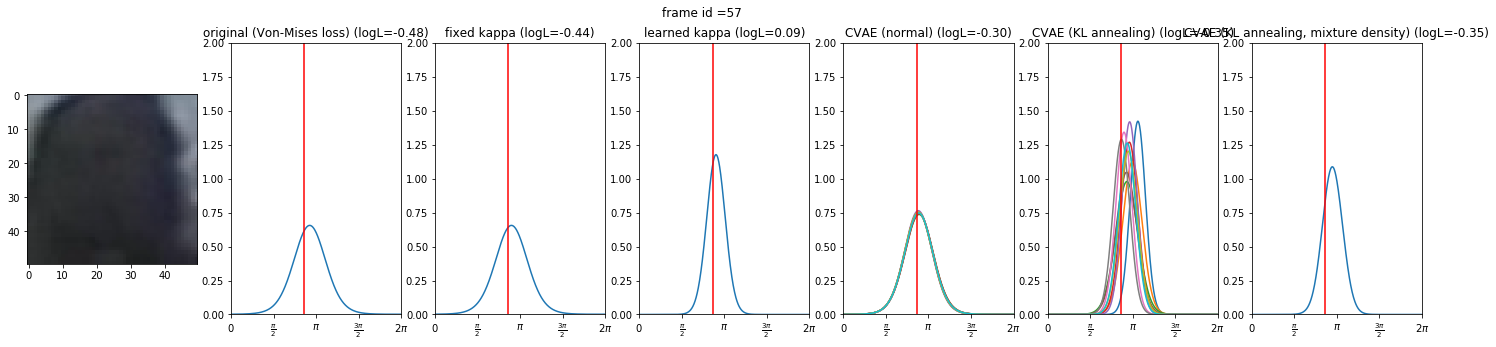

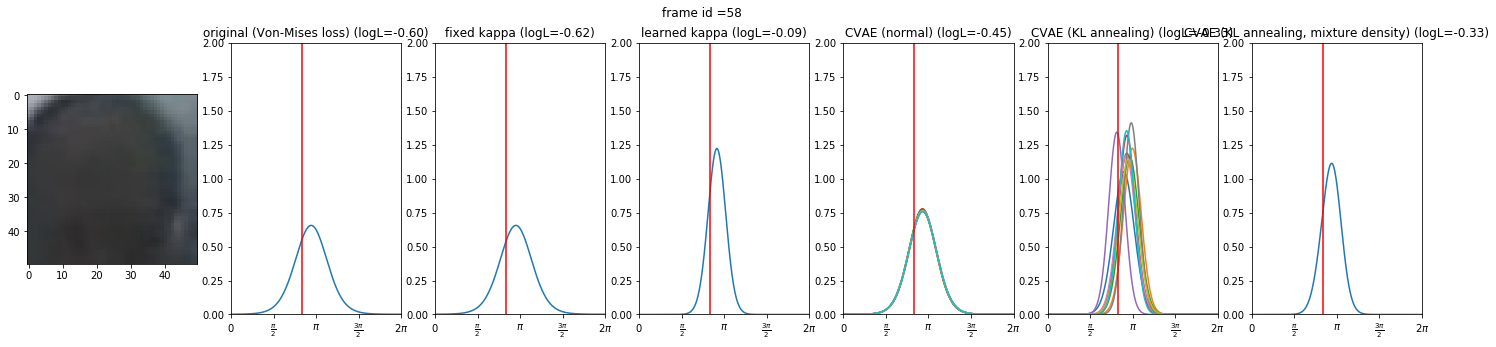

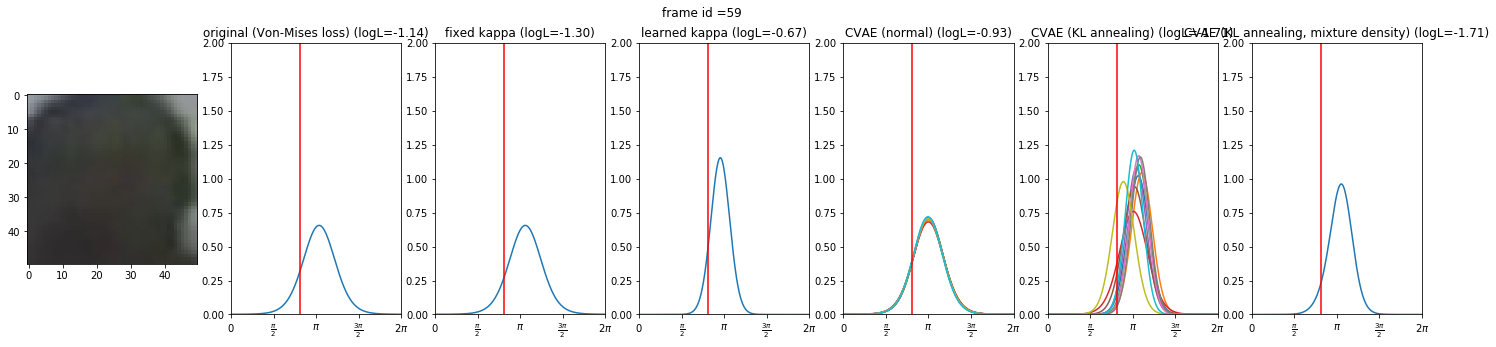

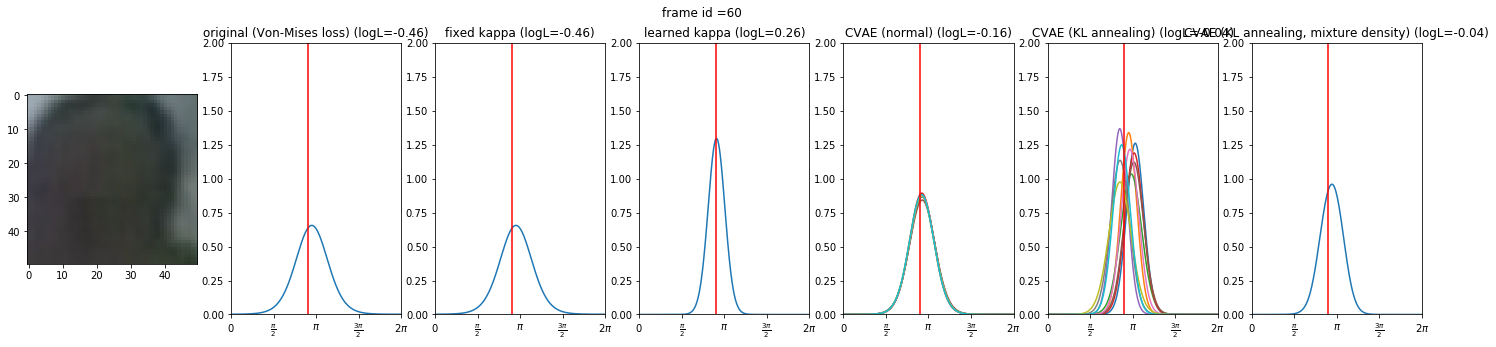

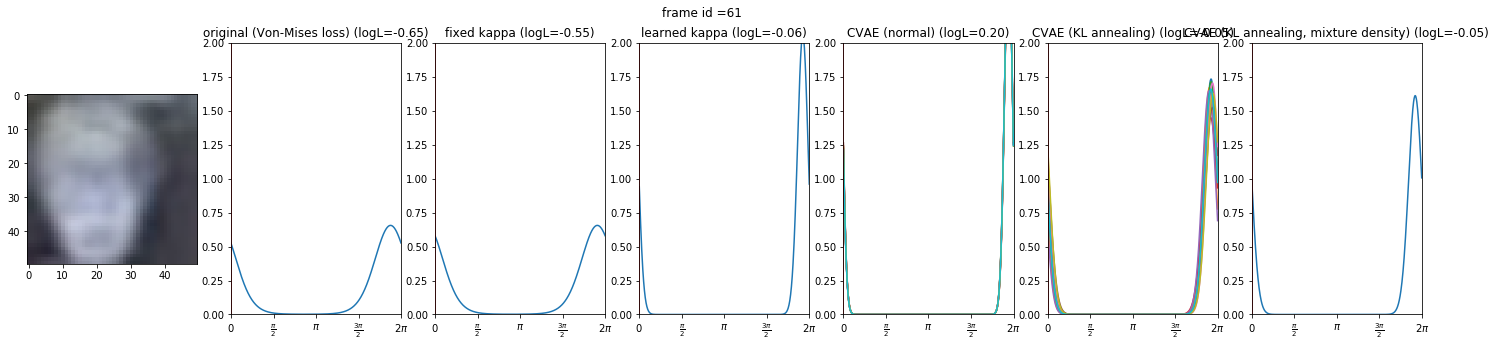

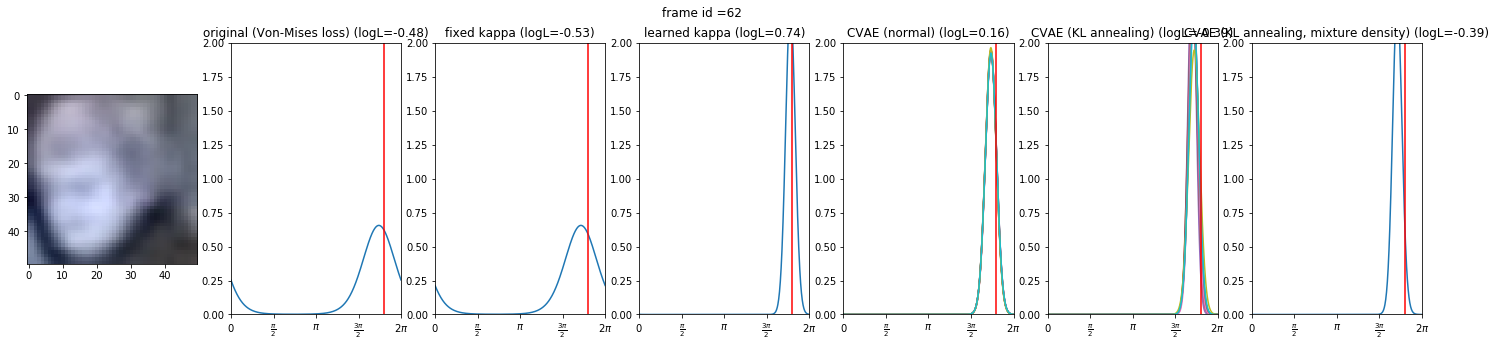

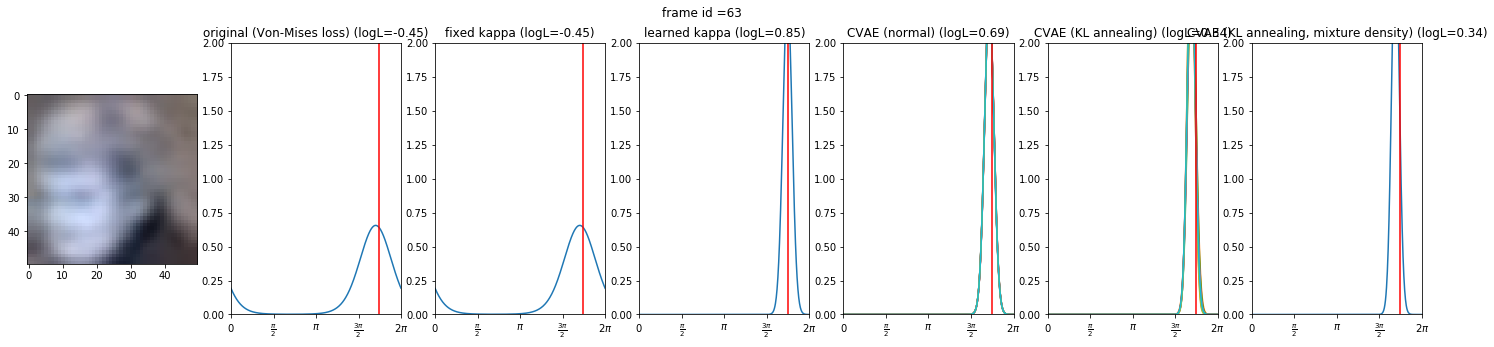

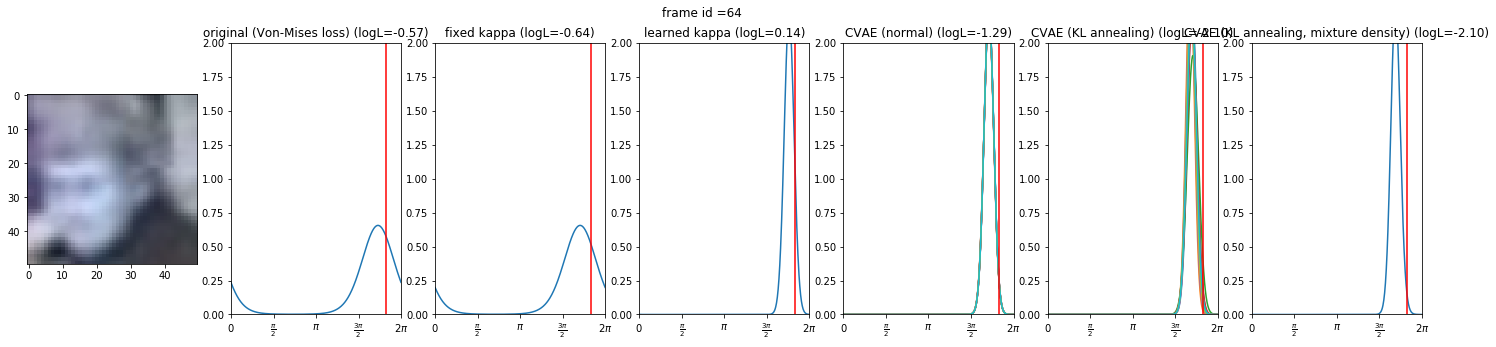

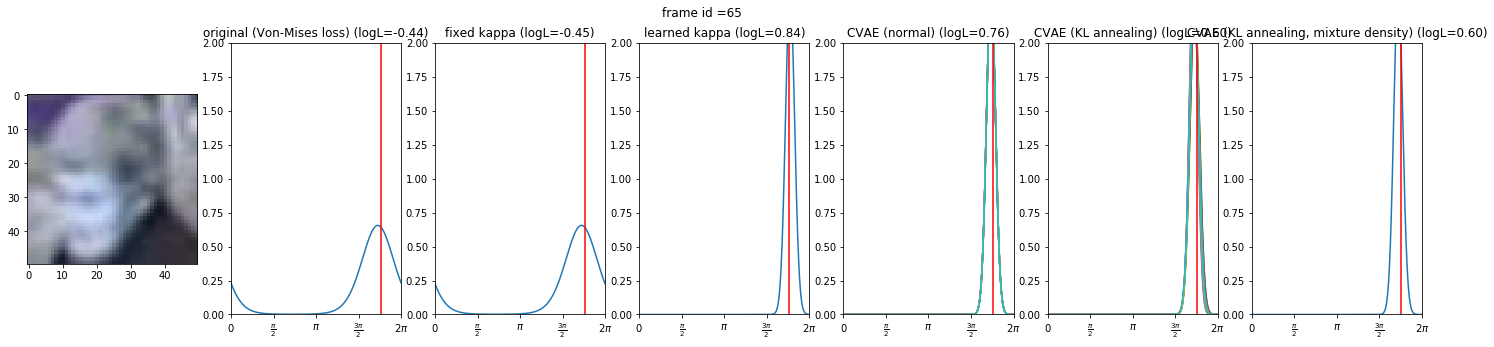

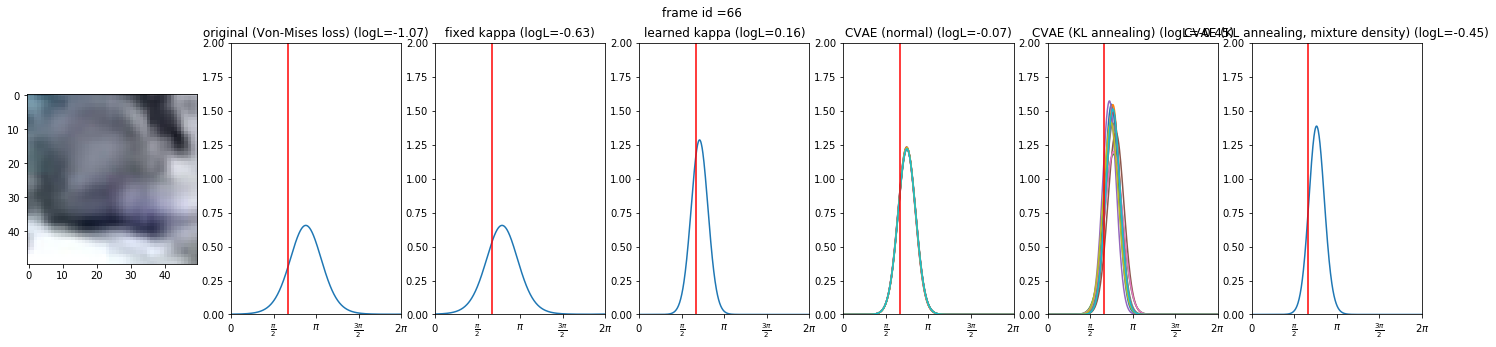

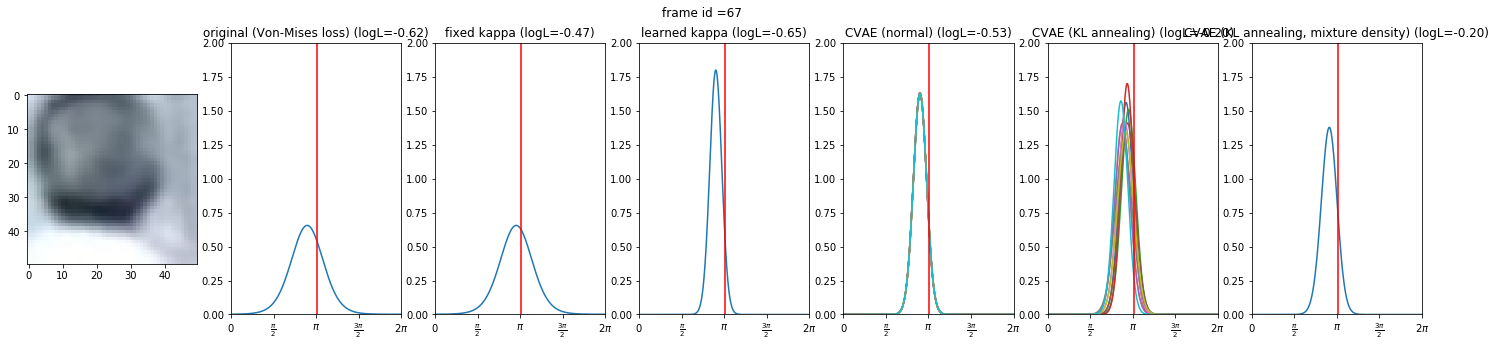

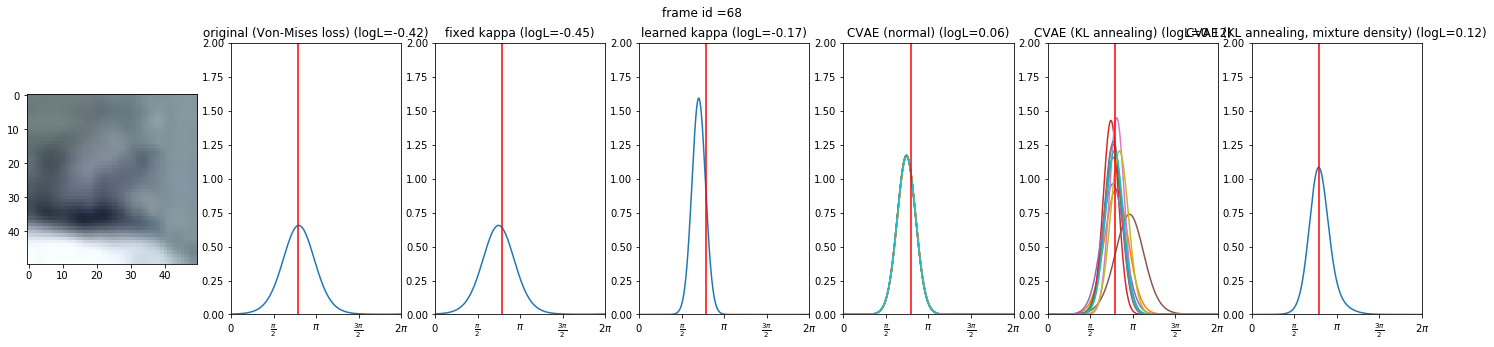

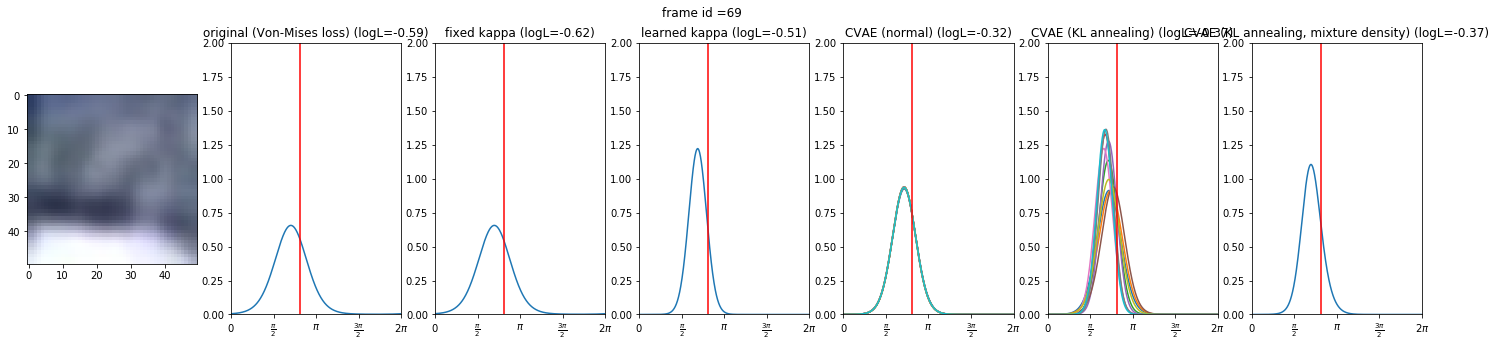

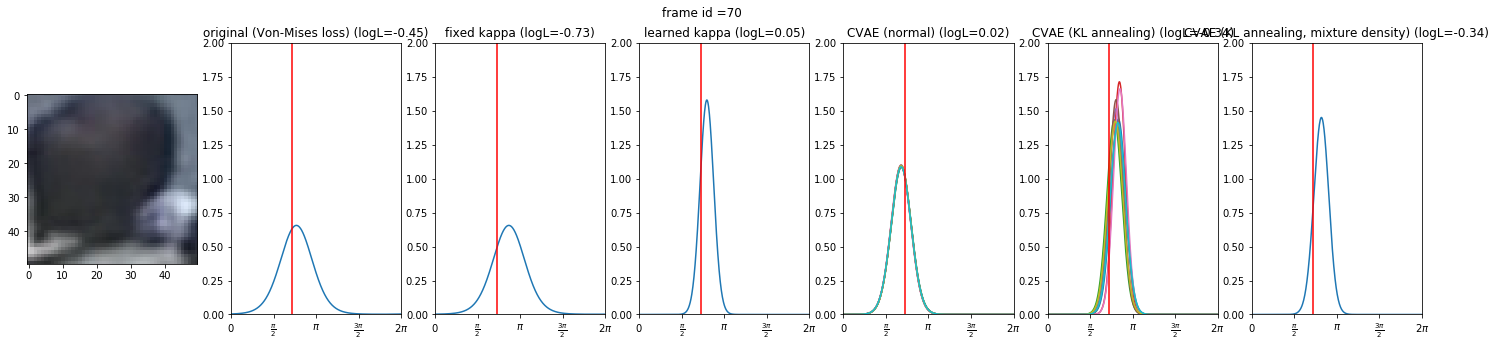

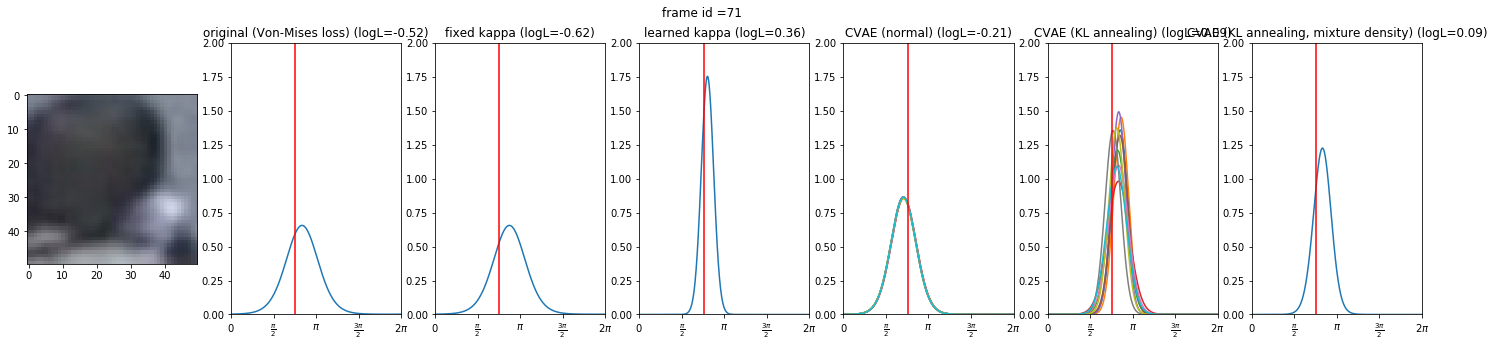

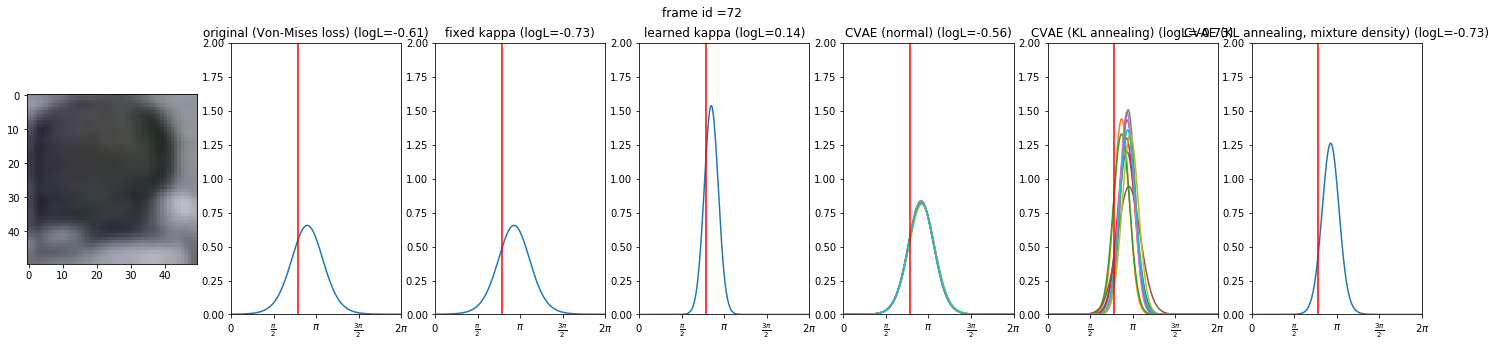

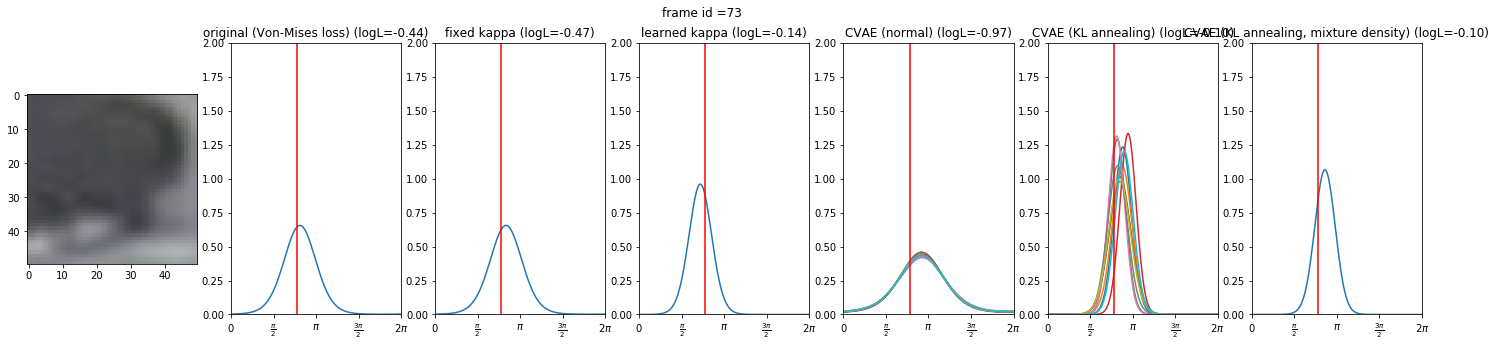

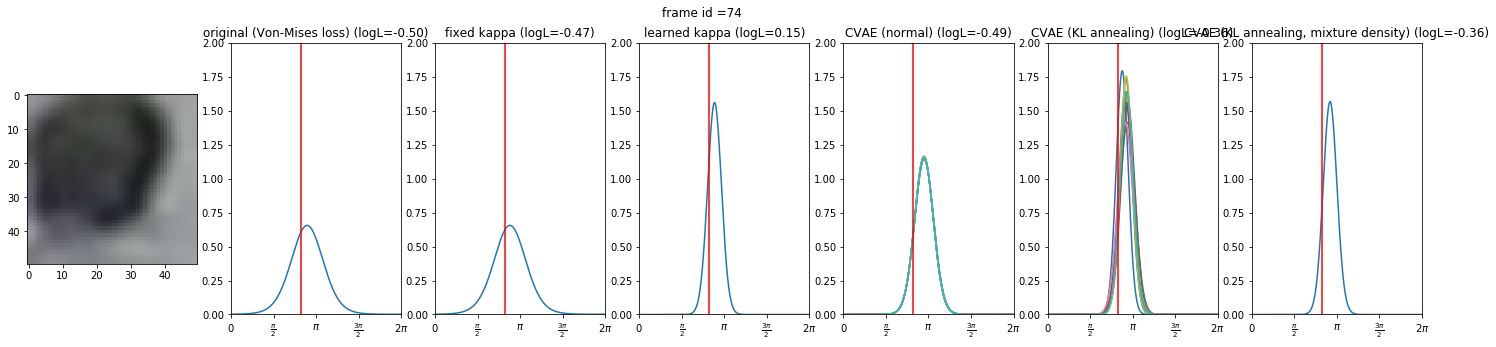

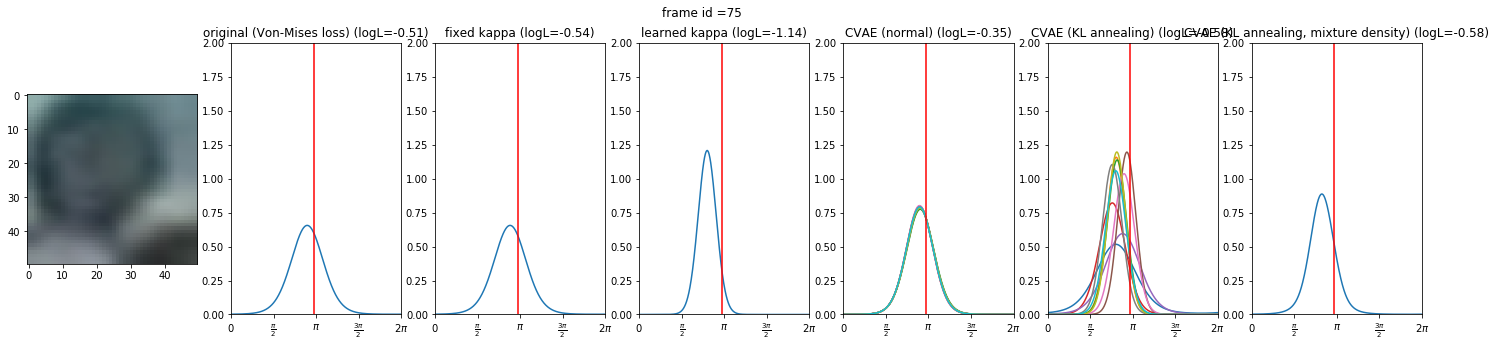

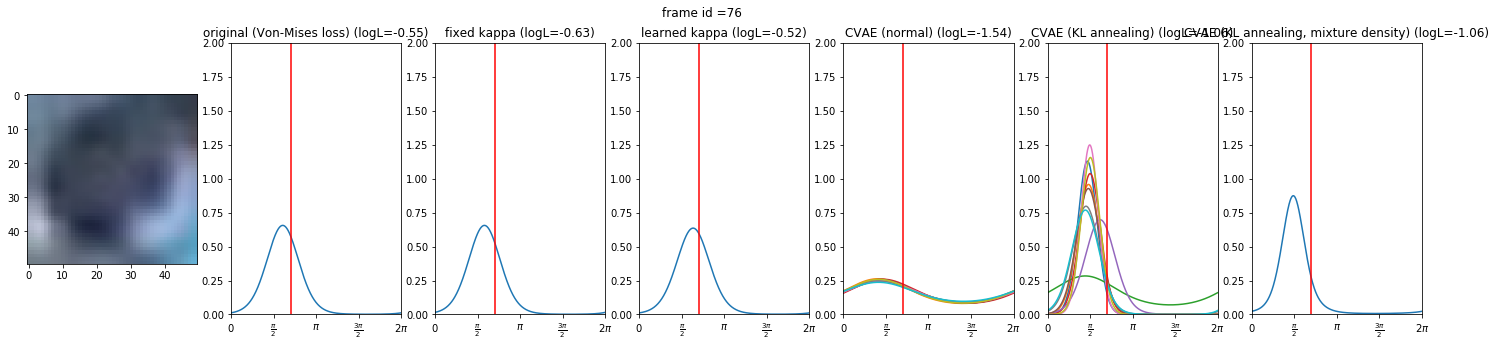

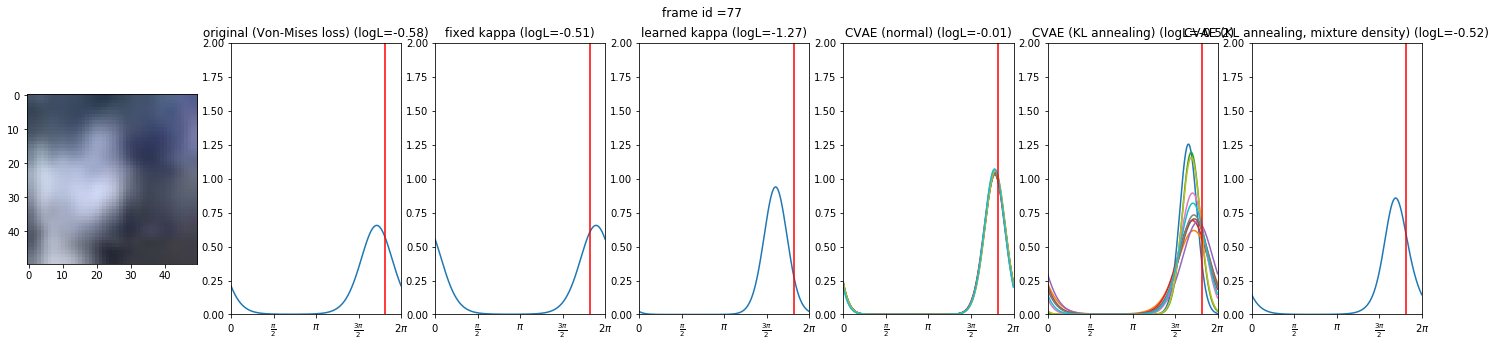

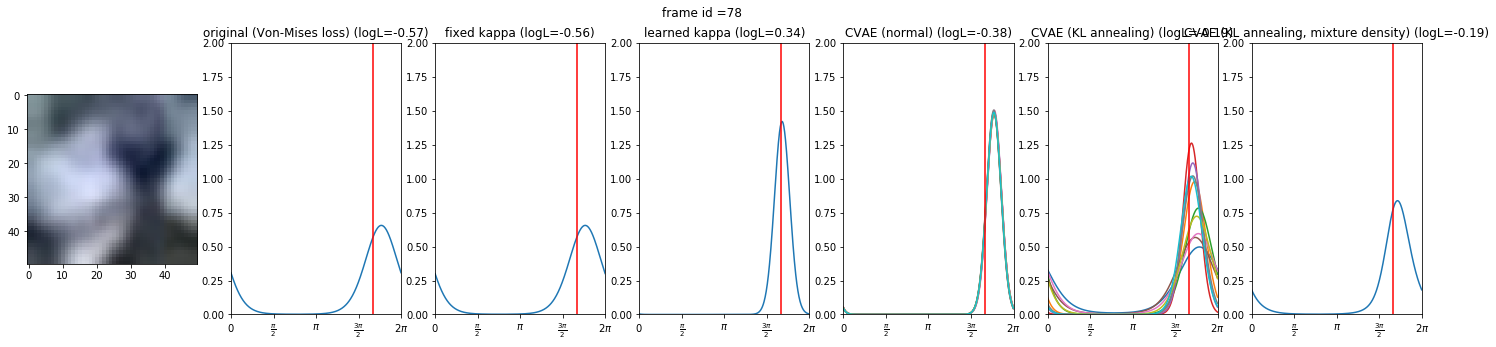

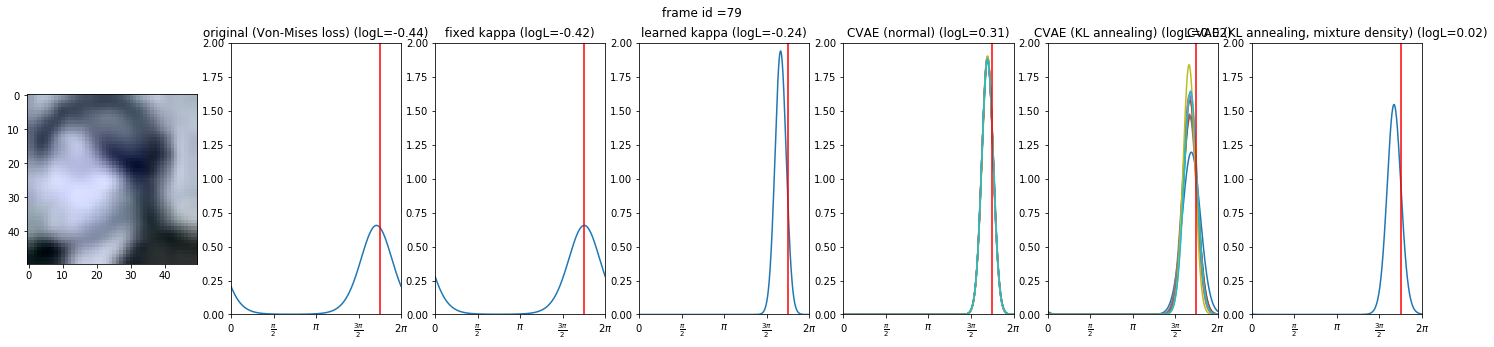

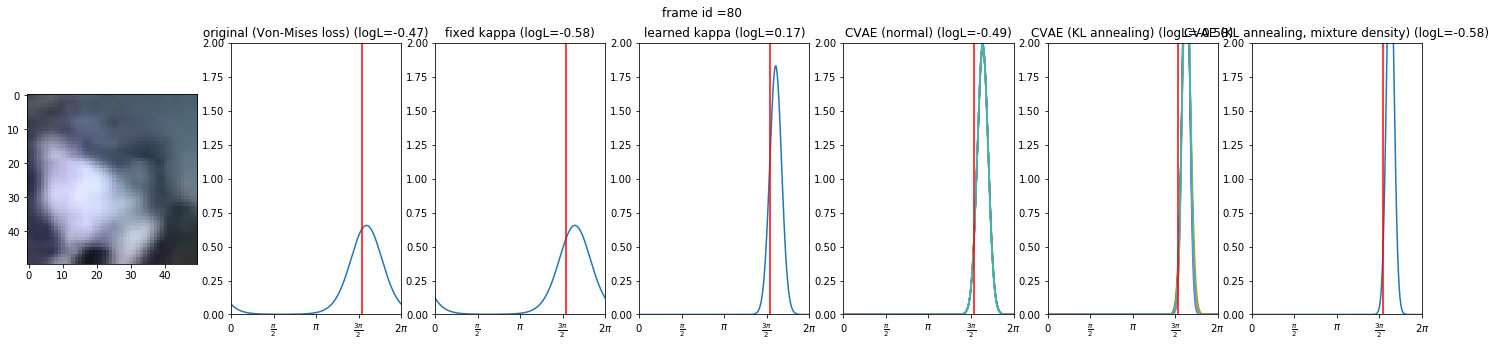

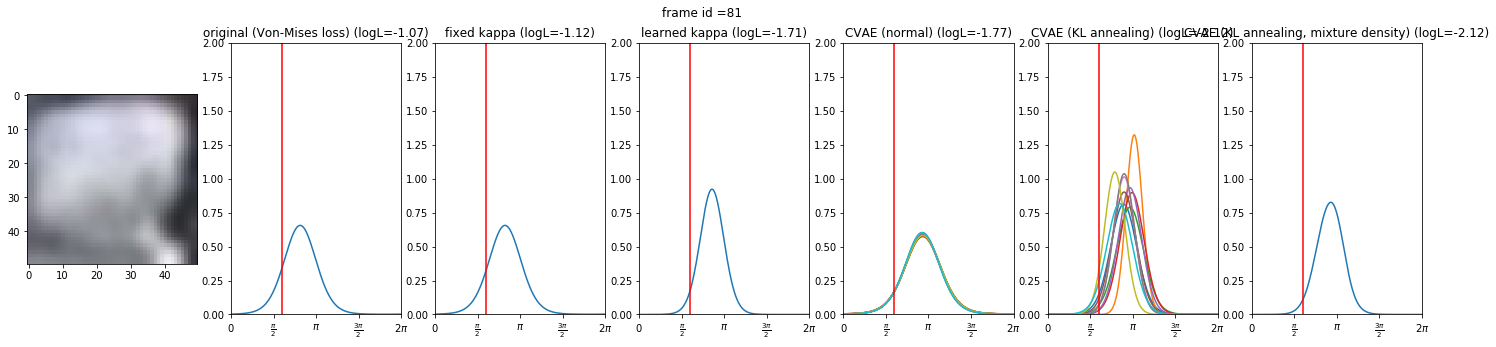

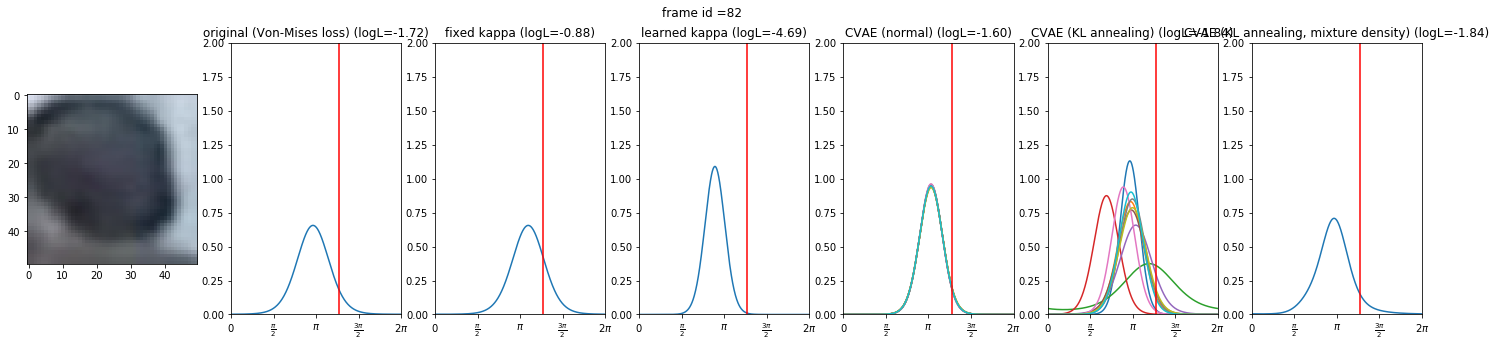

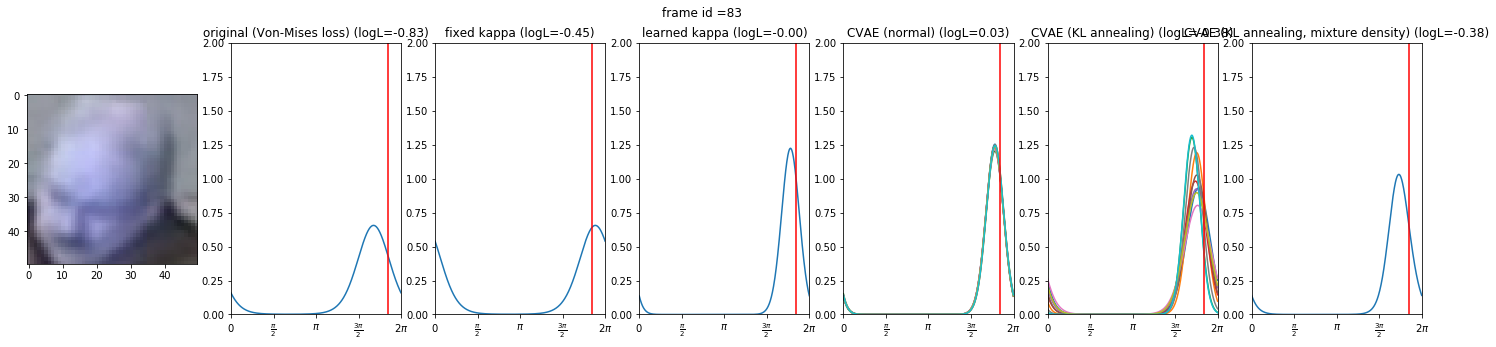

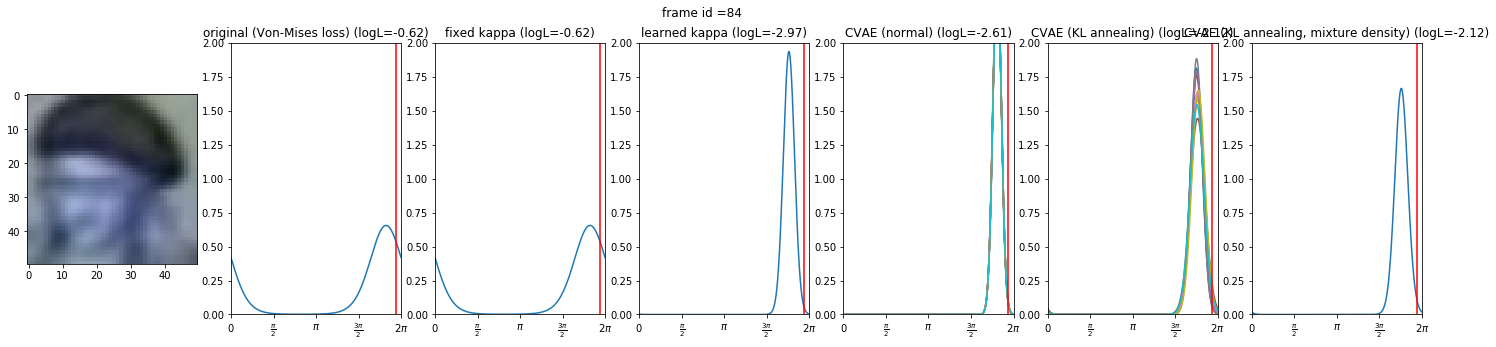

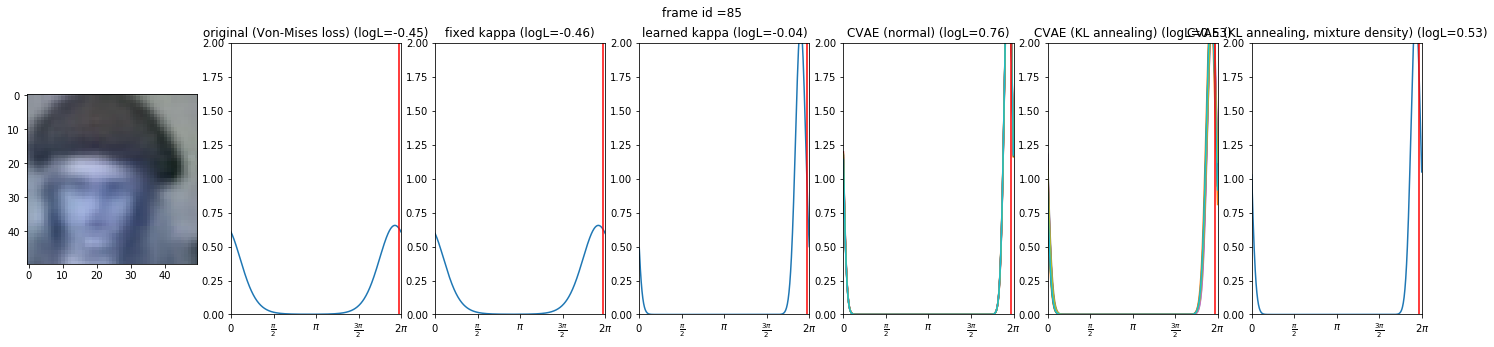

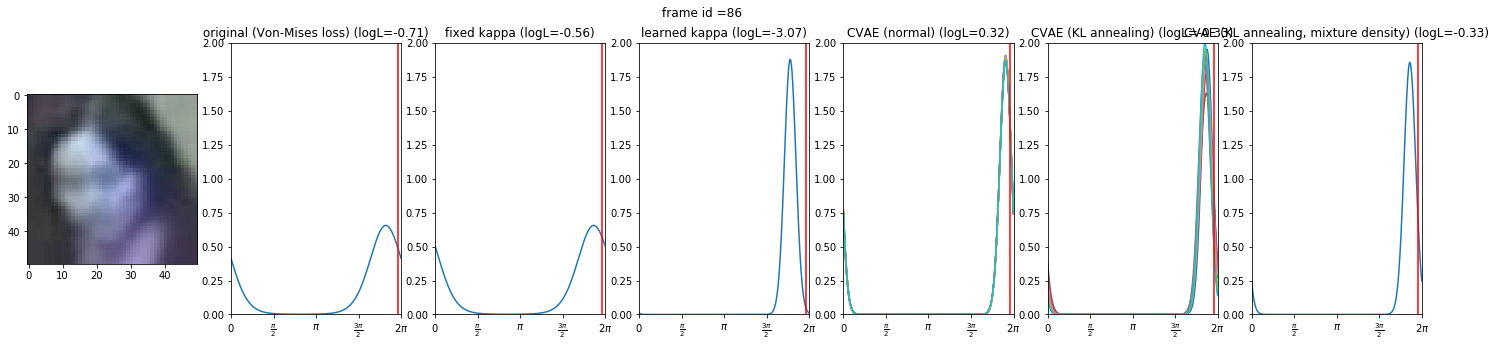

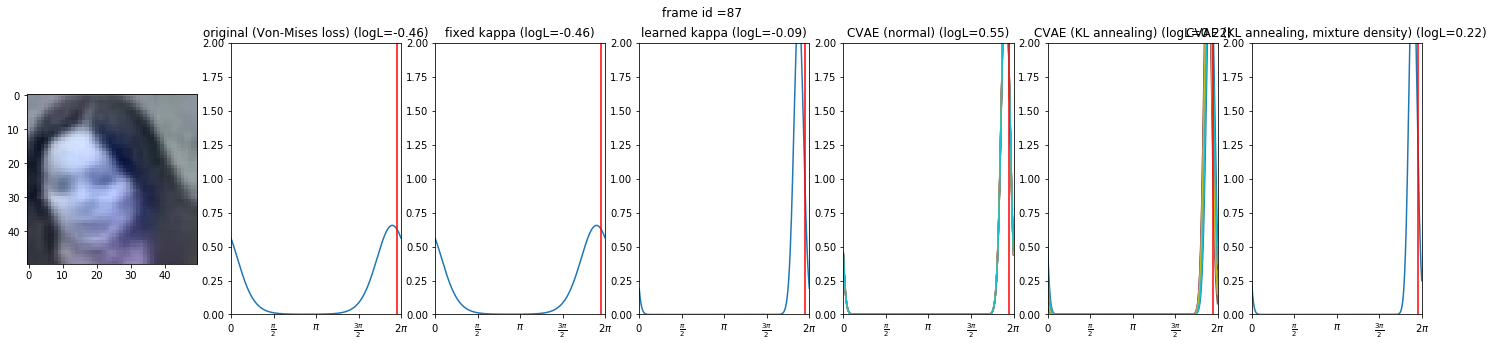

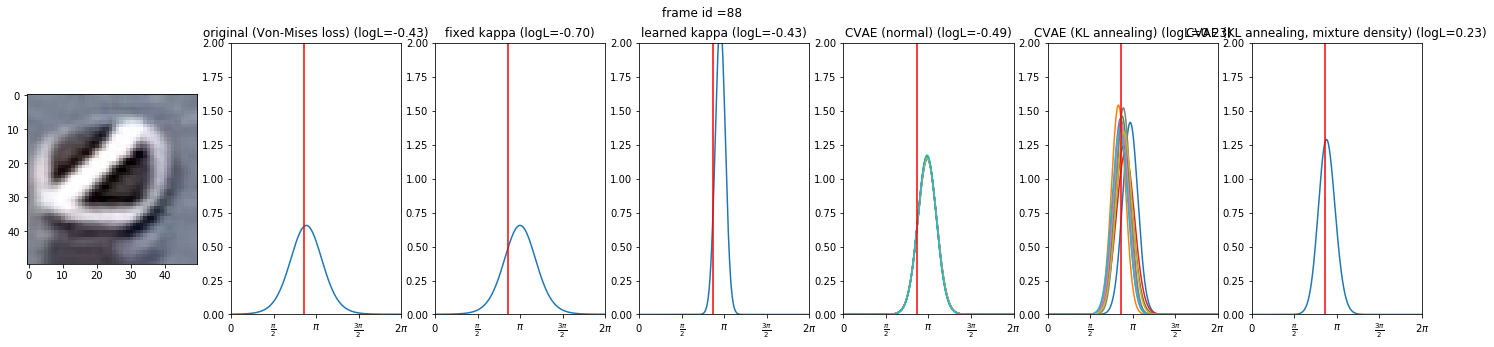

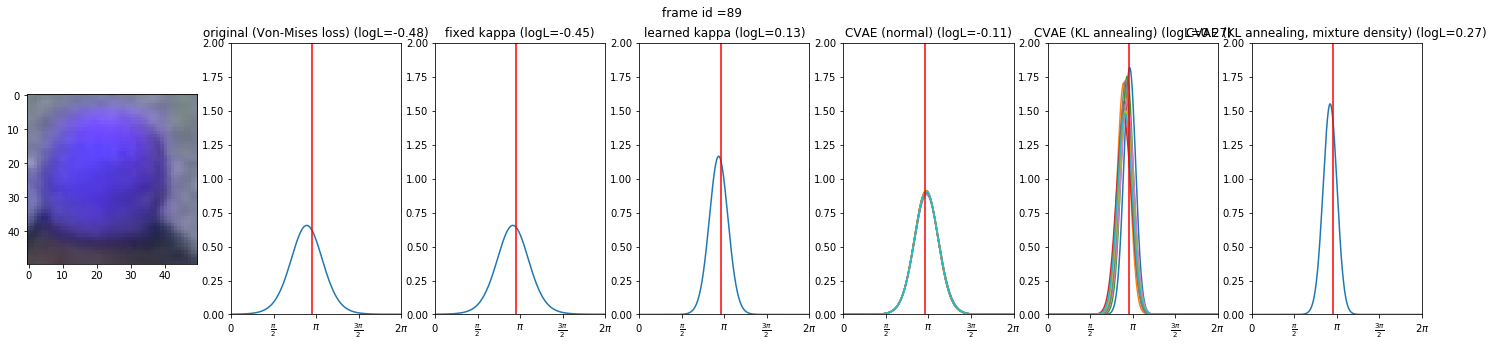

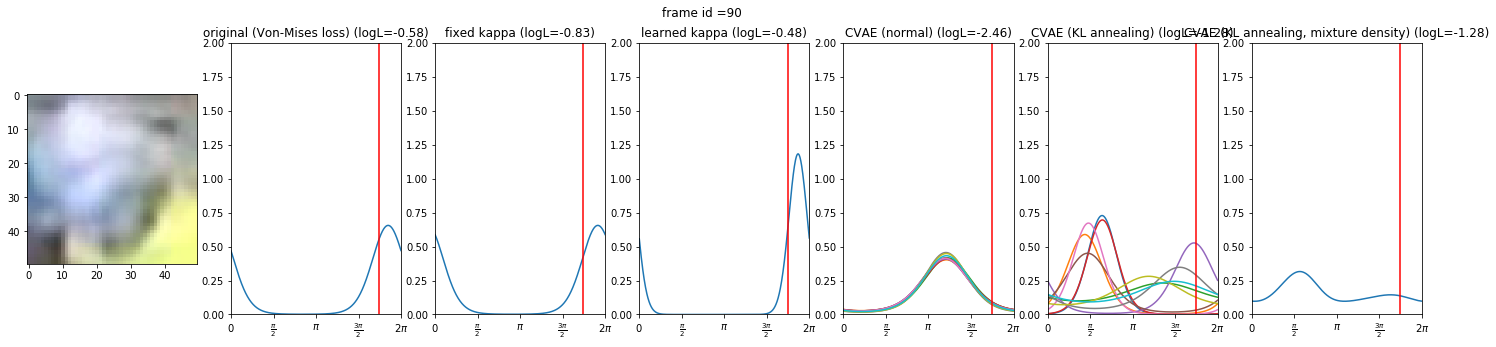

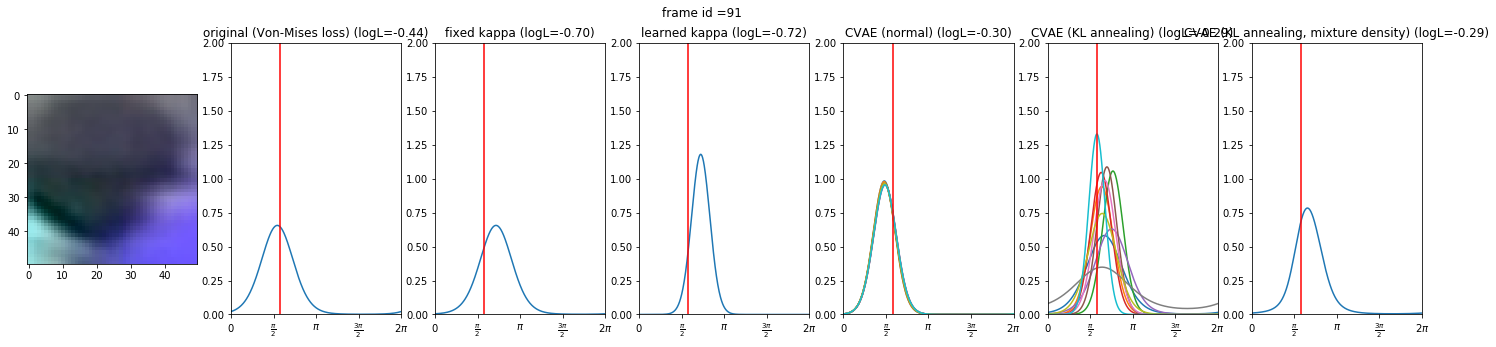

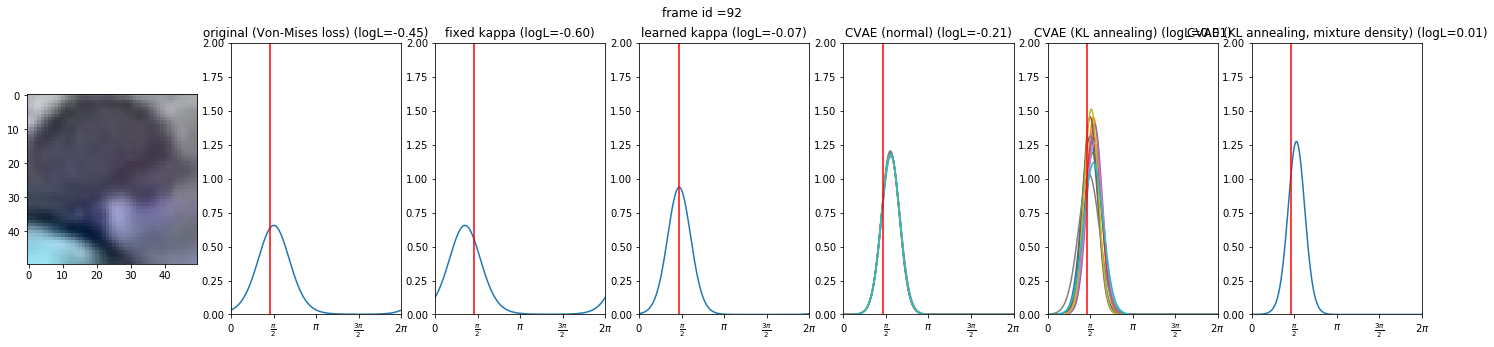

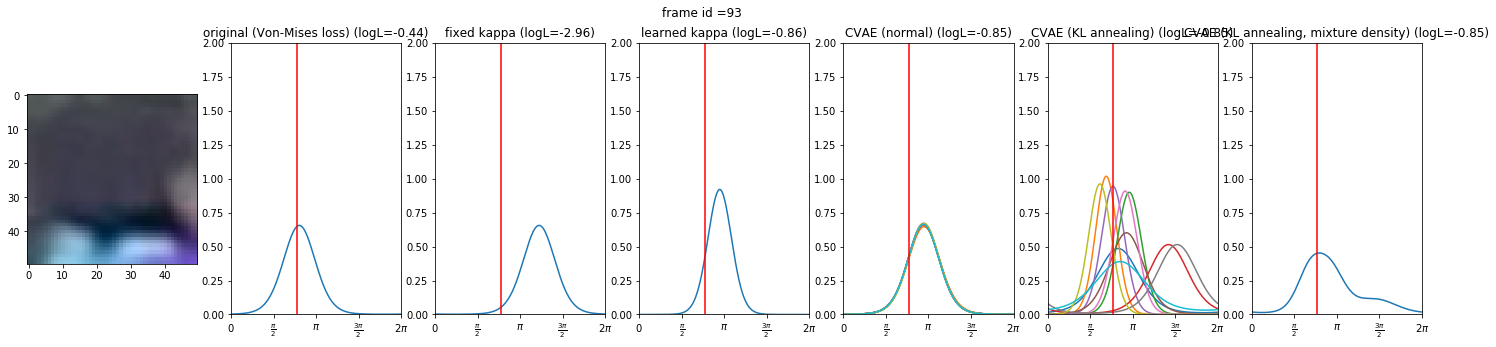

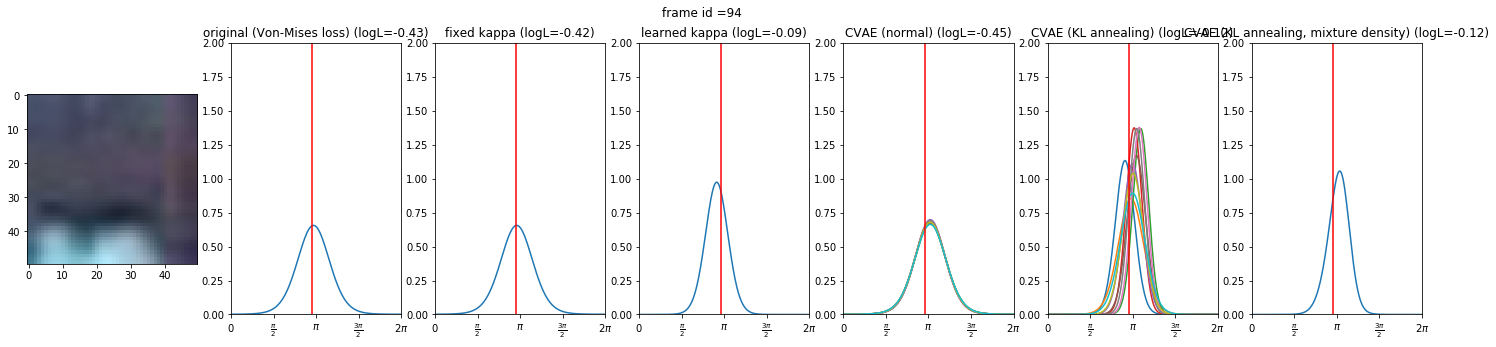

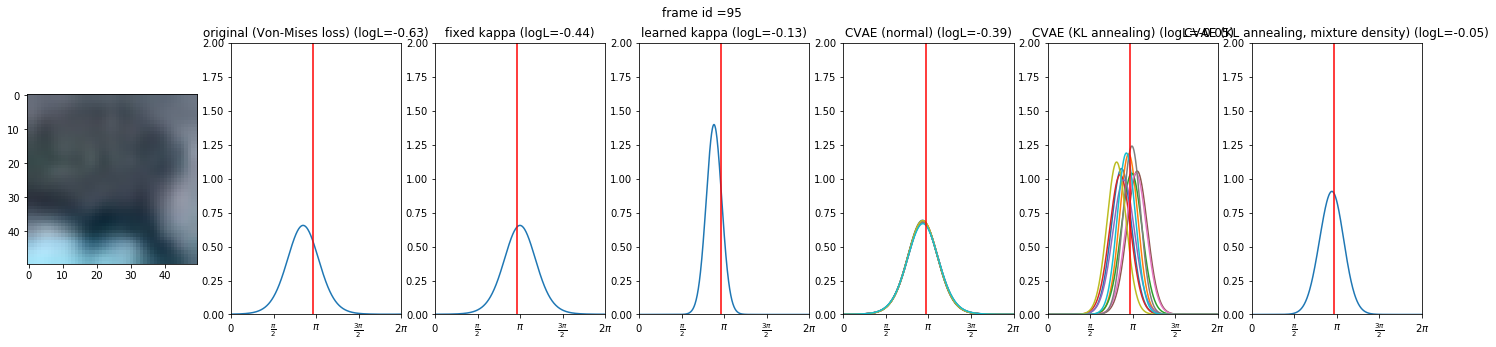

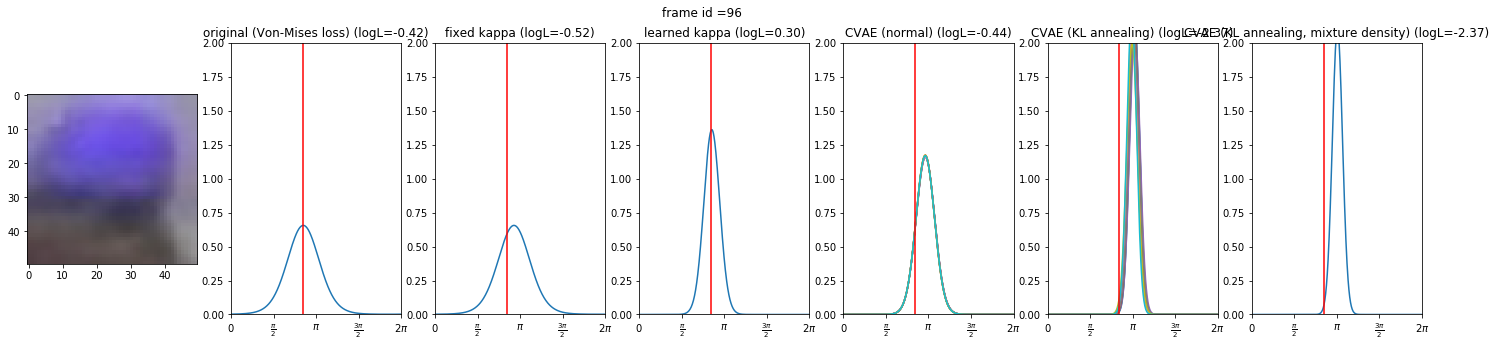

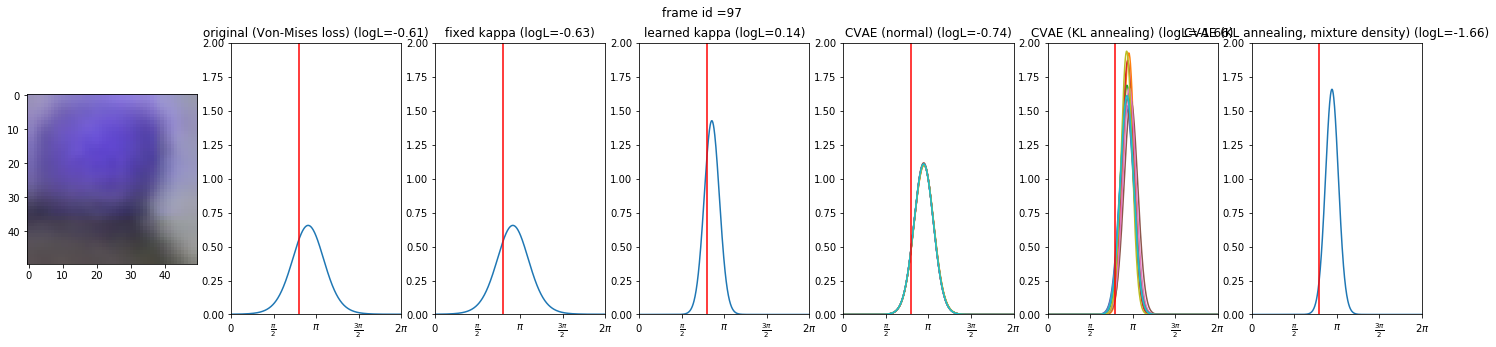

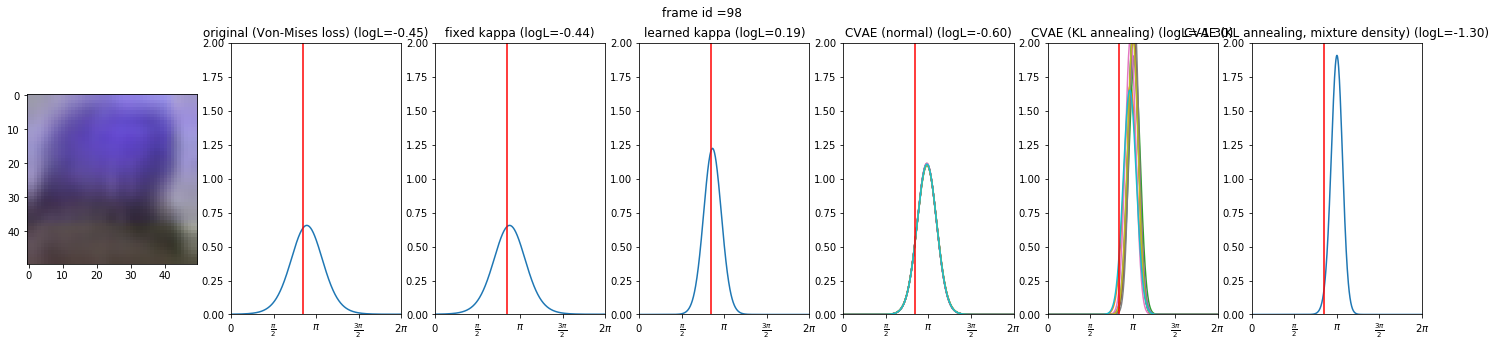

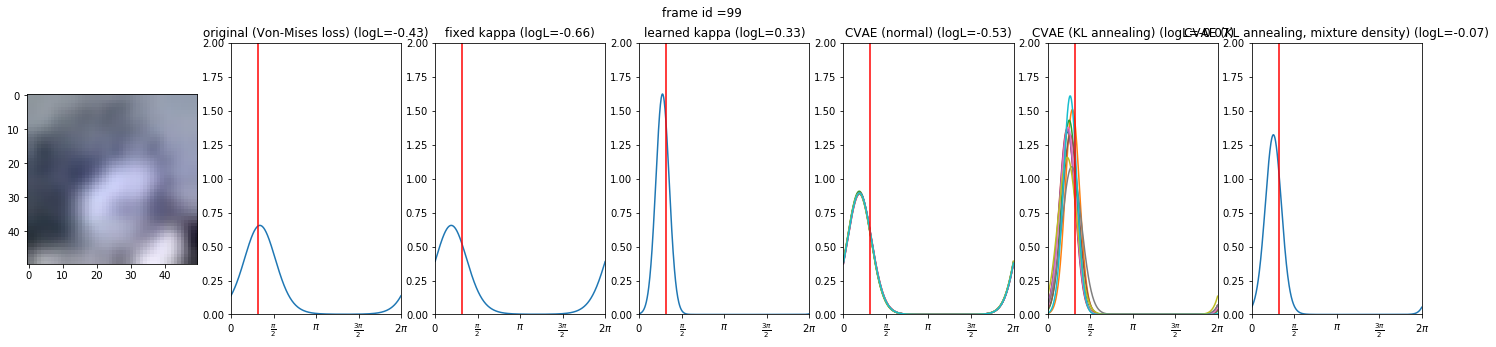

In [18]:
import time 

n_samples = 10

for fid in range(50, 100):
    plot_vm_dists(fid)